# Prediction of returns of the most expensive orders

In [31]:
import pandas as pd
import numpy as np
np.random.seed(0)

import gc
from collections import defaultdict 

import re

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [20, 6]

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, cross_validate, cross_val_predict

from sklearn.metrics import mean_squared_error as mse
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from ml_metrics import rmsle
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, classification_report
import scikitplot as skplt

import xgboost as xgb
import eli5
from eli5.sklearn import PermutationImportance

#xgb_params = {
#    'max_depth' : 5, 
#    'n_estimators' : 100, 
#    'learning_rate' : 0.3, 
#    'random_state' : 0
#}

# Hyper-opt params
xgb_params =  {
 'x_colsample_bytree': 0.8296197740954266, 
 'x_learning_rate': 0.06852224453990871, 
 'x_max_depth': 8, 
 'x_min_child_weight': 9, 
 'x_reg_alpha': 2.3970943894022994, 
 'x_reg_lambda': 0.8398422938605985, 
 'x_seed': 4850, 
 'x_subsample': 0.85641702748044,
 'n_estimators': 100,
 'random_state': 0
 }
 
model = xgb.XGBClassifier(**xgb_params)

## Dane:

- `invoice` - nr. faktury
- `stock_code` - produkt ID
- `description` - opis produktu
- `quantity` - liczba kupionych tych samych produktów w ramach jednej transakcji
- `invoice_date` - data wystawienie faktury
- `price_unit` - cena jednostkowa produktu za sztukę w funtach
- `price_total` - cena razem `price_unit * quantity` 
- `customer_id` - klient ID
- `country` - nazwa kraju, z którego klient kupował
- `is_canceled` - czy faktura była anulowana
- `is_test` - czy to zbiór testowy

### Wnioski:
 - `91,69%` Klientów z UK
 - dane sprzedaży z 2 lat (12.2009, 2010, 2011)
 - sprzedaż tylko w ciągu dnia (9-17) - sklep stacjonarny?
 - soboty niehandlowe
 - średni procent zwrotów: 1,92% (UK: 1.77%) 
 - zwracane są główie pojedyncze rzeczy?

In [32]:
train_df = pd.read_hdf('../input/train_online_retail.h5')
test_df = pd.read_hdf('../input/test_online_retail.h5')
print('train_df.shape',train_df.shape)
print('test_df.shape',test_df.shape)

print(test_df['stock_code'].nunique())

# join datasets
frames = [train_df, test_df]
df_all = pd.concat(frames, sort=False)

## release memory
del train_df, test_df
gc.collect()

train_df.shape (520142, 11)
test_df.shape (547229, 10)
5019


15

In [33]:
def group_to_dict(group_key, agg_func=np.sum):
    train = df_all[ ~df_all['is_canceled'].isnull()]
    dict_ = train.groupby(group_key)['is_canceled'].agg(agg_func).to_dict()
    if -1 in dict_: del dict_[-1]    
    mean = np.mean( list(dict_.values()) )
    return defaultdict(lambda: mean, dict_)

def group_to_mgu(group_key, agg_func=np.sum):
    train = orders[ ~df_all['is_canceled'].isnull()]
    dict_ = train.groupby(group_key)['invoice'].agg(agg_func).to_dict()
    if -1 in dict_: del dict_[-1]    
    mean = np.mean( list(dict_.values()) )
    return defaultdict(lambda: mean, dict_)

def is_description_present(r):
    # return 0 if description field is empty
    if not pd.isna(r) == True:
        return 1
    else:
        return 0
    
def is_return(p):
    #word_list=['AMAZON FEE', 'Bank Charges', 'Discount', 'Commission']
    #word_list=['amazon fee', 'bank charges', 'discount', 'commission']
    word_list=['amazon fee', 'commission']
    #gray_list = ['manual']
    try:
        if (len(p) > 0)& (any(word in p.lower() for word in word_list)):
            return 1
        else:
            return 0
    except: 
        return 0 

def is_lowercase(s):
    #detect lowercase (manually added) entries
    try:
        if len(s) > 0:
            clean_str = ''.join(c for c in s if c.isalpha()) # left a-z letters only
            #clean_str = ''.join(filter(str.isalpha, s))      # left a-z letters only
            #clean_str = re.sub(r'[^A-Za-z]', '', s)           # left a-z letters only
            if clean_str[2].islower():
                return 1
            else:
                return 0
    except:
        return -1

def is_weekend(t):
    if t > 4:
        return 1
    else:
        return 0
def is_new_customer(u):
    # new customer: number of orders is == 1
    if u > 1: 
        return 0
    else:
        return 1

#basic feature engineering
def generate_vla_features():
    df_all['cnt_customer_cancel'] = df_all['customer_id'].map(group_to_dict('customer_id')).astype(int)
    df_all['cnt_customer_orders'] = df_all['customer_id'].map(group_to_dict('customer_id', agg_func=np.size)).astype(int)
    
    df_all['cnt_product_cancel'] = df_all['stock_code'].map(group_to_dict('stock_code')).astype(int)
    df_all['cnt_product_orders'] = df_all['stock_code'].map(group_to_dict('stock_code', agg_func=np.size)).astype(int)
    
    df_all['cnt_quantity_cancel'] = df_all['quantity'].map(group_to_dict('quantity')).astype(int)
    df_all['cnt_quantity_orders'] = df_all['quantity'].map(group_to_dict('quantity', agg_func=np.size)).astype(int)
    
    df_all['cnt_country_cancel'] = df_all['country'].map(group_to_dict('country')).astype(int)
    df_all['cnt_country_orders'] = df_all['country'].map(group_to_dict('country', agg_func=np.size)).astype(int)
    
    df_all['cnt_country_ratio'] = (df_all['cnt_country_cancel'] / df_all['cnt_country_orders']*100).astype(int)
    df_all['is_expensive'] = df_all['price_total'].apply(lambda x: x > 100).astype(int)
    
    # return 9 most common countries, group rest as 'other'
    top_countries = list(df_all['country'].value_counts().head(9).keys())
    country_norm = defaultdict(lambda: 'other', dict(zip(top_countries, top_countries)))
    df_all['country_norm'] = df_all['country'].map(country_norm)
    df_all['country_norm'].value_counts()
    

In [34]:
generate_vla_features()
print(df_all.columns)

Index(['invoice', 'stock_code', 'description', 'quantity', 'invoice_date',
       'price_unit', 'price_total', 'customer_id', 'country', 'is_canceled',
       'is_test', 'cnt_customer_cancel', 'cnt_customer_orders',
       'cnt_product_cancel', 'cnt_product_orders', 'cnt_quantity_cancel',
       'cnt_quantity_orders', 'cnt_country_cancel', 'cnt_country_orders',
       'cnt_country_ratio', 'is_expensive', 'country_norm'],
      dtype='object')


In [35]:
returns = df_all[df_all.is_canceled==True]
print(df_all['price_total'].median())

9.949999809265137


In [36]:
#df_all.to_csv('../output/df_all_200410.csv', index=False)
df_all.sample(5)

,invoice,stock_code,description,quantity,invoice_date,price_unit,price_total,customer_id,country,is_canceled,...,cnt_customer_orders,cnt_product_cancel,cnt_product_orders,cnt_quantity_cancel,cnt_quantity_orders,cnt_country_cancel,cnt_country_orders,cnt_country_ratio,is_expensive,country_norm
481967,26748,4530,CHRISTMAS LIGHTS 10 REINDEER,12,2010-11-23 12:04:00,8.500000,102.00,2463,United Kingdom,False,...,98,13,278,597,60467,8428,476922,1,1,United Kingdom
178092,9972,680,LAVENDER SCENTED FABRIC HEART,10,2010-04-28 14:59:00,1.250000,12.50,1595,France,NaN,...,18,4,263,140,20157,251,7318,3,0,France
27814,1398,13,LOVE BUILDING BLOCK WORD,1,2009-12-13 15:54:00,5.949219,5.95,831,United Kingdom,False,...,243,11,890,4445,145752,8428,476922,1,0,United Kingdom
437661,24874,3955,CHILDS GARDEN TROWEL PINK,1,2010-11-07 10:59:00,0.850098,0.85,2116,United Kingdom,False,...,226,1,181,4445,145752,8428,476922,1,0,United Kingdom
1036,60,562,DOOR MAT WELCOME PUPPIES,2,2009-12-01 12:30:00,6.750000,13.50,49,EIRE,NaN,...,2042,5,348,1399,79094,200,9139,2,0,EIRE


In [37]:
n_by_state = df_all.groupby('customer_id')['invoice'].count()
n_by_state 

customer_id
-1       243007
 0           92
 1          855
 2           40
 3         1068
          ...  
 5937         1
 5938        12
 5939        18
 5940         2
 5941        38
Name: invoice, Length: 5943, dtype: int64

In [38]:
# feature engineering
df_all['year'] = df_all.invoice_date.dt.year
df_all['month'] = df_all.invoice_date.dt.month
df_all['day'] = df_all.invoice_date.dt.day
df_all['hour'] = df_all.invoice_date.dt.hour
df_all['minute'] = df_all.invoice_date.dt.minute
df_all['day_of_week'] = df_all.invoice_date.dt.dayofweek
df_all['is_weekend'] = df_all['day_of_week'].apply(lambda x: is_weekend(x)) 
    
df_all['has_description'] = df_all['description'].apply(lambda x : is_description_present(x))
df_all['description'] = df_all['description'].astype(str)
df_all['is_lowercase'] = df_all['description'].apply(lambda x :is_lowercase(x))
df_all['is_return'] = df_all['description'].apply(lambda x :is_return(x))

#df_all['non_return'] = df_all['is_return']
#df_all['is_new_customer'] = df_all['cnt_customer_orders'].apply(lambda x : is_new_customer(x))

df_all['cnt_customer_ratio'] = (df_all['cnt_customer_cancel']/df_all['cnt_customer_orders']*100).astype(int)
df_all['cnt_product_ratio'] = (df_all['cnt_product_cancel']/df_all['cnt_product_orders']*100).astype(int)

df_all['quantity_bin'] = pd.cut(x=df_all['quantity'], bins=[0, 5, 10, 20, 50, 100, 500, 1000, 5000, 10000,50000,100000], labels=['1', '5', '10', '20', '50', '100', '500', '1000', '5000', '10000', '50000'])
df_all['quantity_bin'] = df_all['quantity_bin'].astype(int)

# categorize
cat_feats = ['country', 'country_norm']
for cat_feat in cat_feats:
    df_all['{0}_cat'.format(cat_feat)] = pd.factorize( df_all[cat_feat] )[0]
     
orders = df_all.groupby(['invoice'], as_index=False).agg(
        {
         'is_canceled': 'sum',
         'price_total': 'sum',
         'is_expensive': 'sum',  
         'customer_id' : 'first',
         'quantity': 'sum',
         'quantity_bin' : 'sum',
         'is_return': 'min',
         #'invoice_date': 'first',
         'description':';'.join, #astype(str)
         'country': 'first',
         'country_norm': 'first',   
         'country_cat': 'first',
         'country_norm_cat': 'first',
         'year': 'first',
         'month': 'first',
         'day': 'first',
         'day_of_week': 'first',   
         'hour': 'first',
         'minute': 'first',
         'is_weekend': 'first',
         'is_lowercase': 'sum',
         'has_description': 'min',
         #'is_new_customer': 'first',  
         
         'cnt_customer_cancel': 'first',
         'cnt_customer_orders': 'first',
         'cnt_product_cancel': 'first',
         'cnt_product_orders': 'first',
         'cnt_quantity_cancel': 'first',
         'cnt_quantity_orders': 'first',
         'cnt_country_cancel': 'first',
         'cnt_country_orders': 'first',
            
         'cnt_customer_ratio' :  'first',
         'cnt_product_ratio' :  'first',
         'cnt_country_ratio' : 'first',  
         'is_test' : 'first',
        })

o_list = orders.groupby('customer_id')['invoice'].count()

orders['customer_total_orders'] = orders['customer_id'].apply(lambda x :o_list[x])
orders['new_customer'] = orders['customer_total_orders'].apply(lambda x : x<2).astype(int)
orders['items_in_order'] = orders['description'].apply(lambda x : str(x).count(';')+1).astype(int)

orders.replace([np.inf, -np.inf], 0)

,invoice,is_canceled,price_total,is_expensive,customer_id,quantity,quantity_bin,is_return,description,country,...,cnt_quantity_orders,cnt_country_cancel,cnt_country_orders,cnt_customer_ratio,cnt_product_ratio,cnt_country_ratio,is_test,customer_total_orders,new_customer,items_in_order
0,0,0,505.299988,1,0,166,115,0,15CM CHRISTMAS GLASS BALL 20 LIGHTS;PINK CHERR...,United Kingdom,...,60467,8428,476922,38,8,1,True,10,0,8
1,1,0,145.800003,0,0,60,50,0,"CAT BOWL ;DOG BOWL , CHASING BALL DESIGN;HEART...",United Kingdom,...,60467,8428,476922,38,1,1,True,10,0,4
2,2,0,630.330017,1,1,193,135,0,DOOR MAT BLACK FLOCK ;LOVE BUILDING BLOCK WORD...,United Kingdom,...,20157,8428,476922,8,0,1,False,95,0,19
3,3,0,310.750000,0,2,145,110,0,CHRISTMAS CRAFT HEART DECORATIONS;CHRISTMAS CR...,United Kingdom,...,42314,8428,476922,0,2,1,False,2,0,23
4,4,0,2286.239990,10,3,826,670,0,DINOSAURS WRITING SET ;SET OF MEADOW FLOWER ...,United Kingdom,...,144,8428,476922,0,0,1,False,153,0,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53623,53623,0,124.599998,0,122,76,40,0,LUNCH BAG RED RETROSPOT;6 CHOCOLATE LOVE HEART...,United Kingdom,...,1013,8428,476922,8,2,1,False,73,0,2
53624,53624,0,140.639999,0,122,120,70,0,RED FLOCK LOVE HEART PHOTO FRAME;6 CHOCOLATE L...,United Kingdom,...,1927,8428,476922,8,2,1,False,73,0,2
53625,53625,0,329.049988,0,4982,278,214,0,BLACK TEA TOWEL CLASSIC DESIGN;ASSORTED BOTTLE...,United Kingdom,...,60467,8428,476922,2,0,1,False,19,0,21
53626,53626,0,339.200012,1,2187,66,50,0,LARGE CAKE STAND HANGING STRAWBERY;SET OF 3 H...,United Kingdom,...,12885,8428,476922,27,11,1,True,60,0,4


In [39]:
orders[['invoice', 'customer_id', 'customer_total_orders','new_customer', 'description', 'items_in_order']].sample(5)

,invoice,customer_id,customer_total_orders,new_customer,description,items_in_order
39521,39521,3040,33,0,BLACK RECORD COVER FRAME,1
35202,35202,-1,8752,0,ASSORTED COLOURS SILK FAN;EDWARDIAN PARASOL BL...,173
24645,24645,-1,8752,0,nan,1
27700,27700,4333,2,0,RED RETROSPOT CAKE STAND,1
46707,46707,627,8,0,12 MESSAGE CARDS WITH ENVELOPES;SET OF 3 NOTEB...,6


In [40]:
o_by_state = orders.groupby('customer_id')['invoice'].count()
o_by_state

customer_id
-1       8752
 0         10
 1         95
 2          2
 3        153
         ... 
 5937       1
 5938       1
 5939       1
 5940       1
 5941       1
Name: invoice, Length: 5943, dtype: int64

In [41]:
def cnt_cutomer_orders(group_key):
    train = orders[ ~orders['is_canceled'].isnull()]
    dict_ = train.groupby(group_key)['invoice'].agg(np.size).to_dict()
    if -1 in dict_: del dict_[-1]    
    mean = np.mean( list(dict_.values()) )
    return defaultdict(lambda: mean, dict_)

o = orders['invoice'].map(cnt_cutomer_orders('customer_id')).astype(int)
o

0         10
1         95
2          2
3        153
4         53
        ... 
53623      7
53624      7
53625      7
53626      7
53627      7
Name: invoice, Length: 53628, dtype: int64

In [42]:
df_all['quantity'][df_all.quantity_bin.isnull()]

Series([], Name: quantity, dtype: int32)

In [43]:
#generate_mgu_features()
#print(df_all.columns)

In [44]:
print(orders.columns)
#orders_train.to_csv('../output/orders_train_200409.csv', index=False)

Index(['invoice', 'is_canceled', 'price_total', 'is_expensive', 'customer_id',
       'quantity', 'quantity_bin', 'is_return', 'description', 'country',
       'country_norm', 'country_cat', 'country_norm_cat', 'year', 'month',
       'day', 'day_of_week', 'hour', 'minute', 'is_weekend', 'is_lowercase',
       'has_description', 'cnt_customer_cancel', 'cnt_customer_orders',
       'cnt_product_cancel', 'cnt_product_orders', 'cnt_quantity_cancel',
       'cnt_quantity_orders', 'cnt_country_cancel', 'cnt_country_orders',
       'cnt_customer_ratio', 'cnt_product_ratio', 'cnt_country_ratio',
       'is_test', 'customer_total_orders', 'new_customer', 'items_in_order'],
      dtype='object')


In [45]:
orders_train = orders[orders.is_test == 0].copy()
orders_test = orders[orders.is_test == 1].copy()

del df_all
del orders
gc.collect()

orders_train['is_canceled'] = orders_train['is_canceled'].astype(bool)
#orders_train['price_total']= orders_train['price_total'].astype(int)
#orders_train['cnt_customer_ratio']= orders_train['cnt_customer_ratio'].astype(np.float32)
#orders_train['cnt_product_ratio']= orders_train['cnt_customer_ratio'].astype(np.float32)

#orders_test['price_total']= orders_test['price_total'].astype(int)
#orders_test['cnt_customer_ratio']= orders_test['cnt_customer_ratio'].astype(np.float32)
#orders_test['cnt_product_ratio']= orders_test['cnt_customer_ratio'].astype(np.float32)

print(orders_train.shape)
print(orders_test.shape)

# Train: (520142, 11)
# Test:  (547229, 10)

(26814, 37)
(26814, 37)


In [46]:
def get_feats(df):
    feats = df.select_dtypes([np.number, np.bool]).columns
    black_list = ['is_canceled', 'is_test']
    #black_list = ['is_canceled', 'is_test', 'year','is_weekend','minute','day','has_description', 'day_of_week']
    return [x for x in feats if x not in black_list]

#feats = get_feats(orders_train)

#eli feats
#feats = ['price_total', 'cnt_customer_cancel', 'quantity', 'customer_id', 'cnt_customer_orders', 'quantity_bin', 
#         'is_lowercase', 'hour', 'country_norm_cat', 'day','cnt_customer_ratio', 'cnt_product_ratio']

#eli new feats
#feats = ['price_total', 'cnt_customer_cancel', 'cnt_product_cancel', 'quantity', 
#         'customer_id', 'cnt_customer_orders', 'cnt_product_orders', 'quantity_bin', 
#         'cnt_quantity_cancel', 'cnt_quantity_orders', 'is_lowercase',
#         'cnt_customer_ratio', 'cnt_product_ratio', ]

#feats=['price_total', 'cnt_customer_cancel', 'cnt_product_cancel', 
#       'quantity', 'customer_id', 'quantity_bin', 'cnt_product_ratio', 
#       'cnt_customer_ratio', 'cnt_quantity_cancel', 'cnt_product_orders', 
#       'cnt_quantity_orders', 'is_lowercase']

#feats = ['price_total', 'cnt_customer_cancel', 'quantity', 'customer_total_orders', 
# 'cnt_product_cancel', 'cnt_product_ratio', 'quantity_bin', 'cnt_customer_ratio', 
# 'cnt_product_orders', 'customer_id', 'cnt_quantity_cancel', 'cnt_quantity_orders','is_lowercase']

feats = ['cnt_customer_cancel', 'price_total', 'items_in_order', 'cnt_product_cancel', 
         'customer_total_orders', 'quantity', 'cnt_product_ratio', 'cnt_quantity_cancel', 
         'cnt_customer_ratio', 'customer_id', 'cnt_product_orders', 'cnt_customer_orders']


print(feats)
X = orders_train[feats].values
y = orders_train['is_canceled'].values


def simple_split_model(model, X,y):
    #train and predict
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(confusion_matrix(y_test.astype(int), y_pred.astype(int)))
    print(classification_report(y_test.astype(int), y_pred.astype(int)))   
    print(mean_squared_error(y_test.astype(int), y_pred.astype(int)))
    
    #skplt.estimators.plot_feature_importances(model, feature_names=feats, title='Features importance', x_tick_rotation=90, figsize=(15, 5));
    #skplt.estimators.plot_learning_curve(model, X_train, y_train,'Learning Curve',cv=5);
    #xgb.plot_importance(model.get_booster(), importance_type='gain')

%time simple_split_model(model,X,y)

['cnt_customer_cancel', 'price_total', 'items_in_order', 'cnt_product_cancel', 'customer_total_orders', 'quantity', 'cnt_product_ratio', 'cnt_quantity_cancel', 'cnt_customer_ratio', 'customer_id', 'cnt_product_orders', 'cnt_customer_orders']
[[4403  105]
 [ 109  746]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      4508
           1       0.88      0.87      0.87       855

    accuracy                           0.96      5363
   macro avg       0.93      0.92      0.93      5363
weighted avg       0.96      0.96      0.96      5363

0.03990303934365094
CPU times: user 4.12 s, sys: 20.2 ms, total: 4.14 s
Wall time: 831 ms


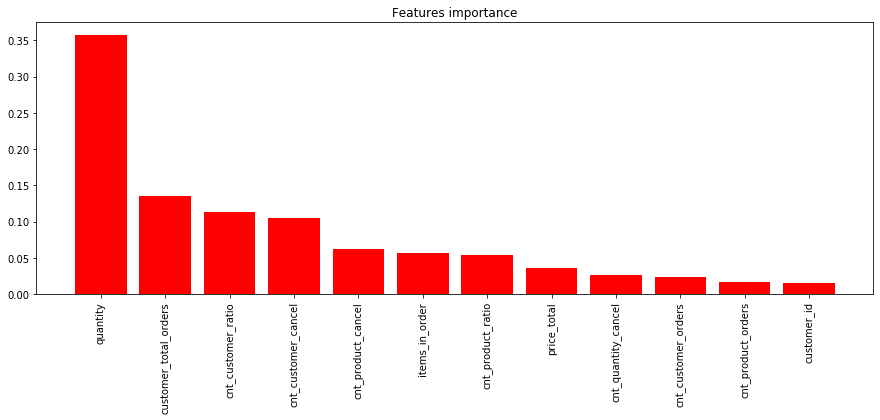

In [108]:
skplt.estimators.plot_feature_importances(model, feature_names=feats, title='Features importance', x_tick_rotation=90, figsize=(15, 5));

CPU times: user 45.5 s, sys: 175 ms, total: 45.7 s
Wall time: 9.16 s


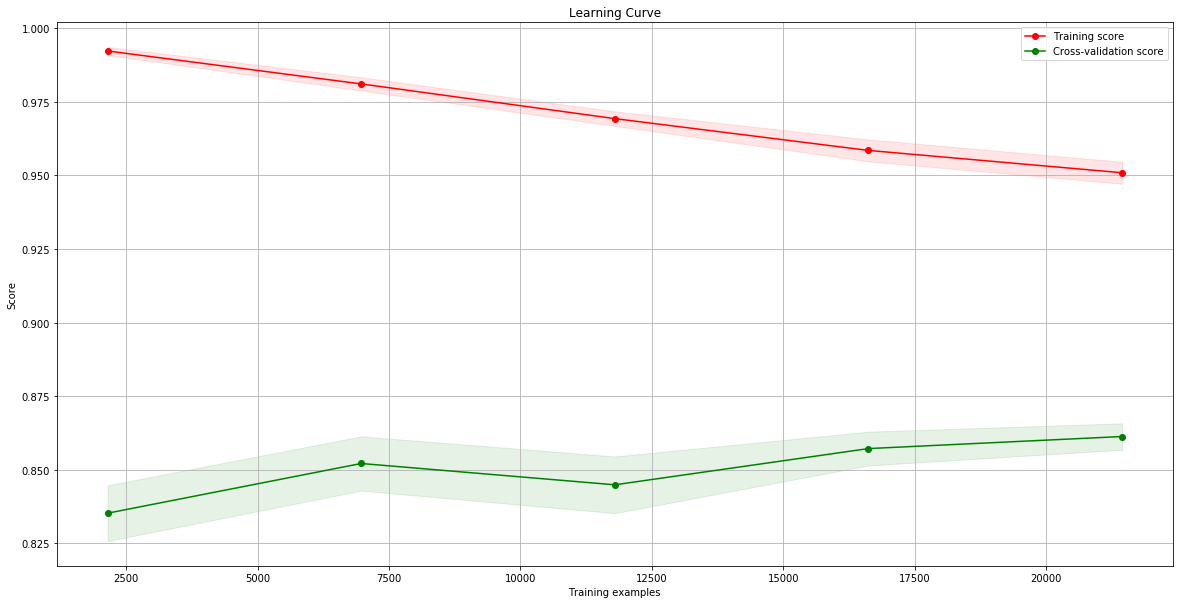

In [80]:
%time _ =skplt.estimators.plot_learning_curve(model, X, y,'Learning Curve',cv=5, n_jobs=1, scoring='recall', figsize=(20,10));

CPU times: user 56.2 s, sys: 192 ms, total: 56.4 s
Wall time: 11.3 s


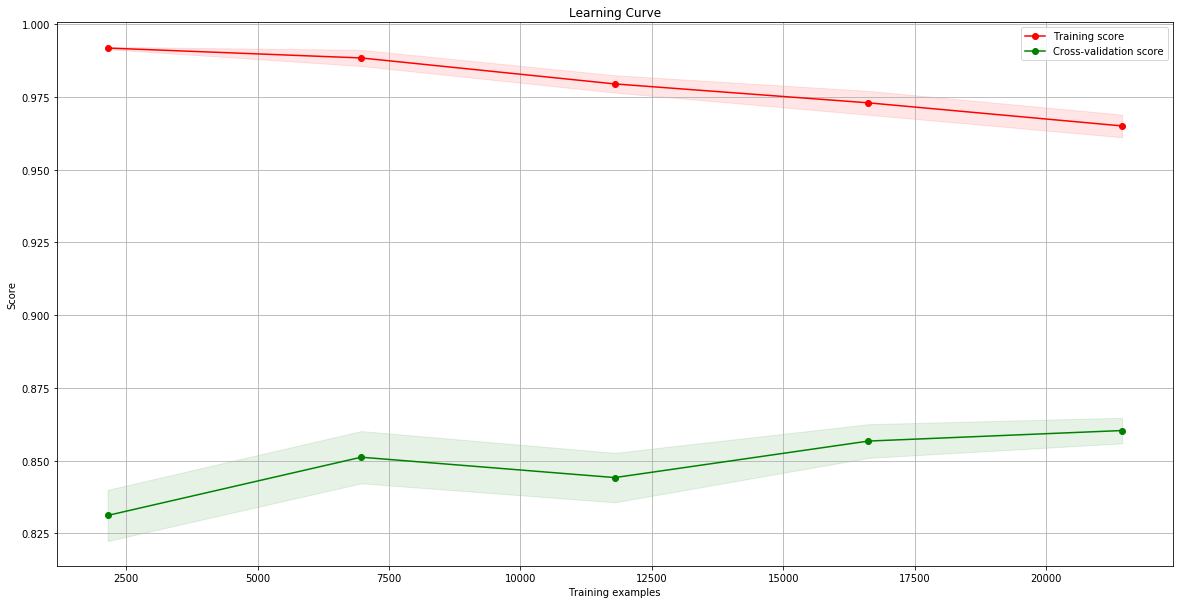

In [109]:
#old
%time skplt.estimators.plot_learning_curve(model, X, y,'Learning Curve',cv=5, n_jobs=1, scoring='recall', figsize=(20,10));

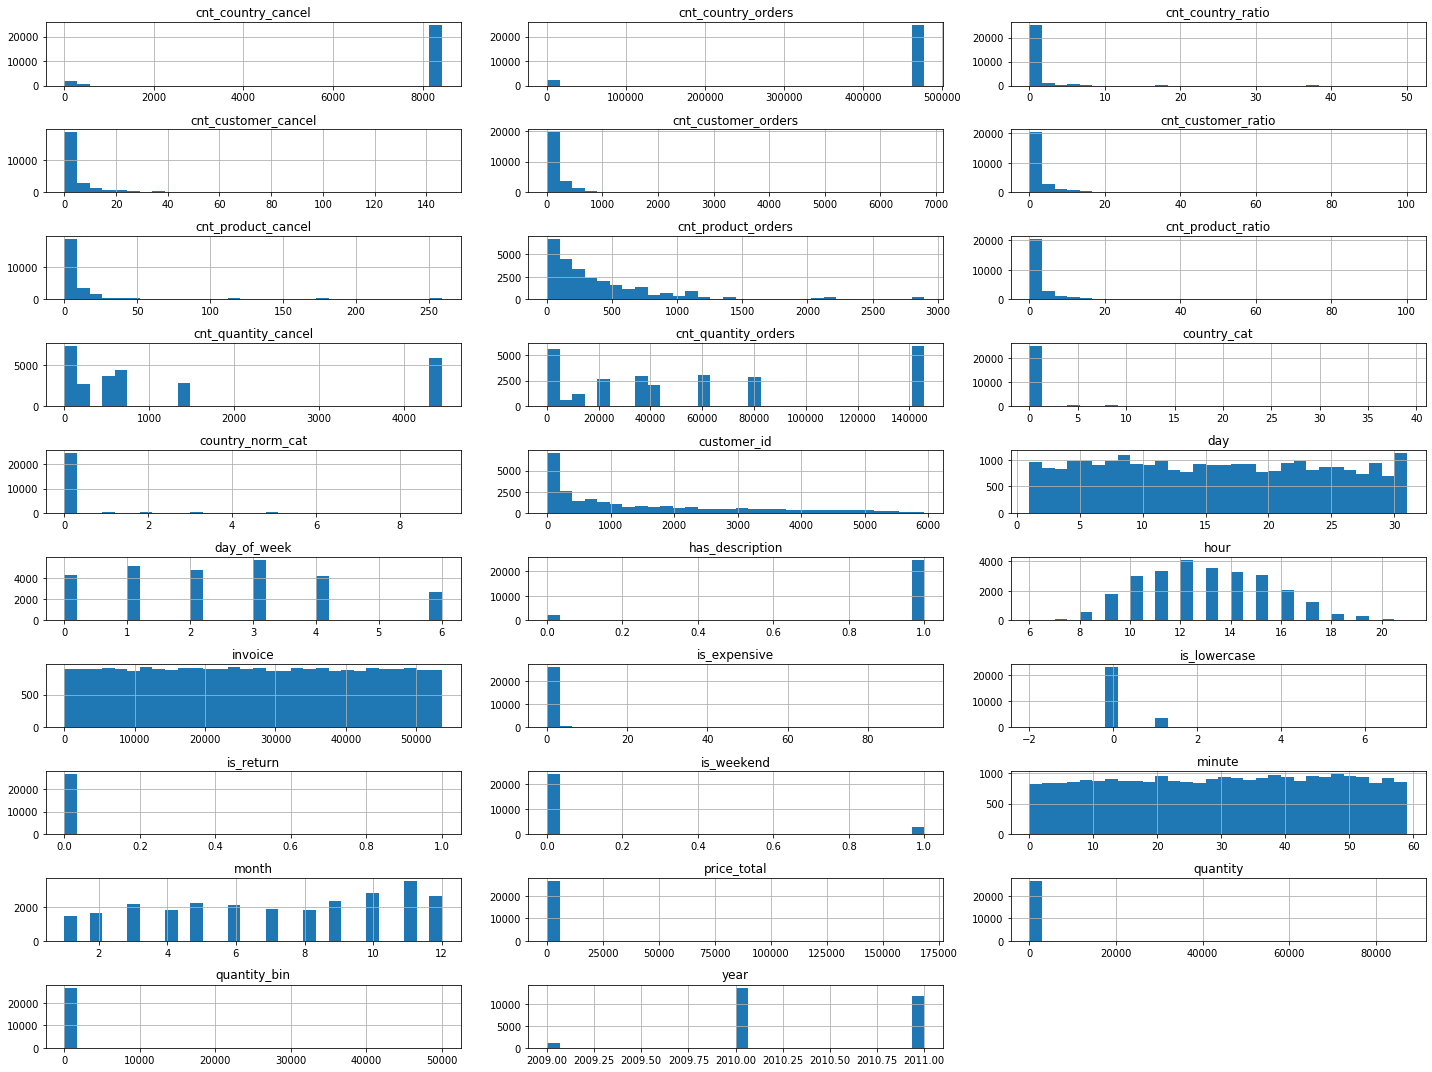

In [204]:
orders_train[feats].hist(bins=30, figsize=(20,15), layout = (10,3));
plt.tight_layout()
plt.show()

In [611]:
orders_test.columns

Index(['invoice', 'is_canceled', 'price_total', 'is_expensive', 'customer_id',
       'quantity', 'quantity_bin', 'is_return', 'country', 'country_norm',
       'country_cat', 'country_norm_cat', 'year', 'month', 'day',
       'day_of_week', 'hour', 'minute', 'is_weekend', 'is_lowercase',
       'has_description', 'cnt_customer_cancel', 'cnt_customer_orders',
       'cnt_customer_ratio', 'cnt_product_ratio', 'is_test'],
      dtype='object')

In [110]:
feats=['price_total', 'cnt_customer_cancel', 'cnt_product_cancel', 
       'quantity', 'customer_id', 'quantity_bin', 'cnt_product_ratio', 
       'cnt_customer_ratio', 'cnt_quantity_cancel', 'cnt_product_orders', 
       'cnt_quantity_orders', 'is_lowercase']

X_train = orders_train[feats].values
y_train = orders_train['is_canceled'].values
X_test = orders_test[feats].values
y_test = orders_test['is_canceled'].values

orders_test['price_total'] = orders_test['price_total'].map(lambda x: abs(x))

def final_model(model, X_train, y_train, X_test, y_test):
    #train and predict
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    return y_pred

    
%time prediction = final_model(model,X_train,y_train, X_test, y_test)

orders_test['total_return'] = prediction * orders_test['price_total']
#orders_test['total_return'] = orders_test['total_return'] * abs(orders_test['is_return']-1) # postprocess
orders_test[ ['invoice', 'total_return'] ].to_csv('../output/mgu_81.csv', index=False) 

# OR:

#y_pred = model.predict(X_test)
#orders_test['total_return'] = y_pred * orders_test['price_total']
#orders_test['total_return'] = orders_test['total_return'] * abs(orders_test['is_return']-1) #postprocess
#orders_test[ ['invoice', 'total_return'] ].to_csv('../output/mgu_74.csv', index=False) 

CPU times: user 4.2 s, sys: 7.98 ms, total: 4.2 s
Wall time: 844 ms


---

# Funkcja pomocnicze

---

## K-fold walidacja

In [30]:
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, BaggingClassifier
import xgboost as xgb
import lightgbm as lgb
import catboost as ctb

models = [
        xgb.XGBClassifier(max_depth=5, n_estimators=100, learning_rate=0.3, seed=0), #0
        #ctb.CatBoostClassifier(depth=5, iterations=100, learning_rate=0.3, random_seed=0), 
        DecisionTreeClassifier(max_depth=10,random_state=0), #1
        AdaBoostClassifier(random_state=0), #2
        BaggingClassifier(random_state=0), #3
        DecisionTreeClassifier(random_state=0), #4
        RandomForestClassifier(n_estimators=50, max_depth=10, min_samples_split=10, min_samples_leaf=5,random_state=0), #5
        ExtraTreesClassifier(n_estimators=50, max_depth=10, min_samples_split=10, min_samples_leaf=5,random_state=0),#6
        ]

def model_train_predict(model, X, y, success_metric=recall_score):
    cv = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
    scores =[]     
    for train_idx, test_idx in cv.split(X,y): 
        model.fit(X[train_idx], y[train_idx]) 
        y_pred = model.predict(X[test_idx]) 
        score = success_metric(y[test_idx], y_pred )
        scores.append(score)    
    
    print(scores)
    print(i, 'mean recall= ', np.mean(scores), 'odchylenie standardowe (std)=' , np.std(scores))
    return scores
    
i = 0   
X = orders_train[feats].values
y = orders_train['is_canceled'].values

for model in models:
    print('Model: ', i)
    score = model_train_predict(model,X,y)
    i=i+1

Model:  0
[0.8614457831325302, 0.8612786489746683, 0.8468033775633294, 0.8866103739445115, 0.8516284680337757]
0 mean recall=  0.861553330329763 odchylenie standardowe (std)= 0.013740498165381131
Model:  1
[0.8156626506024096, 0.8250904704463209, 0.827503015681544, 0.873341375150784, 0.8455971049457177]
1 mean recall=  0.8374389233653552 odchylenie standardowe (std)= 0.020400757718007624
Model:  2
[0.844578313253012, 0.8311218335343787, 0.8250904704463209, 0.8443908323281062, 0.8262967430639324]
2 mean recall=  0.8342956385251501 odchylenie standardowe (std)= 0.008560803975756993
Model:  3
[0.8192771084337349, 0.8190591073582629, 0.8142340168878166, 0.827503015681544, 0.804583835946924]
3 mean recall=  0.8169314168616566 odchylenie standardowe (std)= 0.007503689205638194
Model:  4
[0.7686746987951807, 0.7792521109770808, 0.781664656212304, 0.8057901085645356, 0.7840772014475271]
4 mean recall=  0.7838917551993256 odchylenie standardowe (std)= 0.012145923961827735
Model:  5
[0.857831325

Najlepsze modele:
- `DecisionTreeClassifier`(random_state=0) - 0.4201874697776231
- `BaggingClassifier`(random_state=0) - 0.29377032074566617
- `xgb.XGBClassifier`(max_depth=5, n_estimators=100, learning_rate=0.3, seed=0) - 0.17598006559648574



# eli5 - permutacja ważności cech

In [76]:
feats = get_feats(orders_train)

print(feats)

X_train = orders_train[feats].values
y_train = orders_train['is_canceled'].values


X_sub_train, X_sub_test, y_sub_train, y_sub_test = train_test_split(X_train, y_train, shuffle=True, random_state=0)

model =xgb.XGBClassifier(**xgb_params).fit(X_sub_train, y_sub_train)
perm = PermutationImportance(model).fit(X_sub_test, y_sub_test)
df_eli0=eli5.explain_weights_df (perm, feature_names=feats, top=50)
eli_show0=eli5.show_weights(perm, feature_names=feats, top=50)

['invoice', 'price_total', 'is_expensive', 'customer_id', 'quantity', 'quantity_bin', 'is_return', 'country_cat', 'country_norm_cat', 'year', 'month', 'day', 'day_of_week', 'hour', 'minute', 'is_weekend', 'is_lowercase', 'has_description', 'cnt_customer_cancel', 'cnt_customer_orders', 'cnt_product_cancel', 'cnt_product_orders', 'cnt_quantity_cancel', 'cnt_quantity_orders', 'cnt_country_cancel', 'cnt_country_orders', 'cnt_customer_ratio', 'cnt_product_ratio', 'cnt_country_ratio', 'customer_total_orders', 'new_customer', 'items_in_order']


In [77]:
eli_show0

Weight,Feature
0.0560 ± 0.0015,cnt_customer_cancel
0.0385 ± 0.0026,price_total
0.0348 ± 0.0040,items_in_order
0.0232 ± 0.0015,cnt_product_cancel
0.0179 ± 0.0021,customer_total_orders
0.0110 ± 0.0017,quantity
0.0080 ± 0.0007,cnt_product_ratio
0.0042 ± 0.0014,cnt_quantity_cancel
0.0038 ± 0.0021,cnt_customer_ratio
0.0019 ± 0.0010,customer_id


In [78]:
futures_eli0=list(df_eli0['feature'][0:12])
feats=futures_eli0
print(feats)

['cnt_customer_cancel', 'price_total', 'items_in_order', 'cnt_product_cancel', 'customer_total_orders', 'quantity', 'cnt_product_ratio', 'cnt_quantity_cancel', 'cnt_customer_ratio', 'customer_id', 'cnt_product_orders', 'cnt_customer_orders']


# HyperOpt

In [85]:
import numpy as np
np.random.seed(0)

from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error

from functools import partial
from hyperopt import hp
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

from sklearn.model_selection import KFold
import xgboost as xgb

feats = ['cnt_customer_cancel', 'price_total', 'items_in_order', 
         'cnt_product_cancel', 'customer_total_orders', 'quantity', 
         'cnt_product_ratio', 'cnt_quantity_cancel', 'cnt_customer_ratio', 
         'customer_id', 'cnt_product_orders', 'cnt_customer_orders']


X = orders_train[feats].values
y = orders_train['is_canceled'].values

def objective(space):
    
    xgb_params = {
        'max_depth': int(space['max_depth']),
        'colsample_bytree': space['colsample_bytree'],
        'learning_rate': space['learning_rate'],
        'subsample': space['subsample'],
        'seed': int(space['seed']),
        'min_child_weight': int(space['min_child_weight']),
        'reg_alpha': space['reg_alpha'],
        'reg_lambda': space['reg_lambda'],
        'n_estimators': 50
    }
    
    cv = KFold(n_splits=3, random_state=2018, shuffle=True)
    scores = []
    for train_idx, test_idx in cv.split(X):
        model = xgb.XGBRegressor(**xgb_params)
        model.fit(X[train_idx], y[train_idx])
        y_pred = model.predict(X[test_idx])

        score = mean_squared_error(y[test_idx], y_pred)
        scores.append(score)
    
    
    return{'loss':np.mean(scores), 'status': STATUS_OK }
    
space ={
    'max_depth': hp.quniform ('x_max_depth', 5, 20, 1),
    'colsample_bytree': hp.uniform ('x_colsample_bytree', 0.8, 1.),
    'learning_rate': hp.uniform ('x_learning_rate', 0.05, 0.2),
    'subsample': hp.uniform ('x_subsample', 0.7, 1.),
    'seed': hp.quniform ('x_seed', 0, 10000, 50),
    'min_child_weight': hp.quniform ('x_min_child_weight', 1, 10, 1),
    'reg_alpha': hp.loguniform ('x_reg_alpha', 0., 1.),
    'reg_lambda': hp.uniform ('x_reg_lambda', 0.7, 1.),
}


trials = Trials()
best_params = fmin(fn=objective,
            space=space,
            algo=partial(tpe.suggest, n_startup_jobs=1),
            max_evals=30,
            trials=trials)

print("The best params: ", best_params)

100%|██████████| 30/30 [01:03<00:00,  2.11s/trial, best loss: 0.03214232996106148]
The best params:  {'x_colsample_bytree': 0.885096184493437, 'x_learning_rate': 0.10854399393485326, 'x_max_depth': 8.0, 'x_min_child_weight': 1.0, 'x_reg_alpha': 2.4540737049531334, 'x_reg_lambda': 0.9409003171979454, 'x_seed': 3000.0, 'x_subsample': 0.8979761051508756}


In [209]:
#prepare submit
model = xgb.XGBClassifier(max_depth=5, n_estimators=100, learning_rate=0.3, seed=0)
model.fit(orders_train[feats], orders_train['is_canceled'])
orders_test['is_canceled'] = model.predict(orders_test[feats])

#prepare submit
orders_test['total_return'] = orders_test['price_total'] * orders_test['is_canceled']
result = orders_test.groupby('invoice')['total_return'].agg(np.sum).to_frame().reset_index()
result[ ['invoice', 'total_return'] ].to_csv('../output/xgb_and_cnt_31.csv', index=False)

----